# Introduction

In this tutorial, we demonstrate how to use TrajectoryNet [1] and PHATE [2] (Potential of Heat-diffusion for Affinity-based Transition Embedding) to analyze a 31,000 cell 27-day time course of embryoid body (EB) differentiation. 

We review the following steps:

[1. Loading 10X data](#loading)  
[2. Preprocessing: Filtering, Normalizing, and Transforming](#preprocessing)  
[3. Embedding Data Using PHATE](#embedding)  
[4. Evaluating Dynamics with TrajectoryNet](#trajectory)

References:


1. Tong, A., Huang, J., Wolf, G., van Dijk, D. & Krishnaswamy, S. TrajectoryNet: A Dynamic Optimal Transport Network for Modeling Cellular Dynamics. in Proceedings of the 37th International Conference on Machine Learning (2020). [url](http://proceedings.mlr.press/v119/tong20a/tong20a.pdf)
2. Moon, K. R. et al. Visualizing structure and transitions in high-dimensional biological data. Nature Biotechnoly 37, 1482–1492 (2019). [url](https://doi.org/10.1038/s41587-019-0336-3)

### Time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS,
45
which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.


## 0. Install PHATE

In addition to cloning and installing TrajectoryNet, if you have not already installed PHATE and `scprep`, we can install them from the notebook. You may need to restart the kernel/runtime after installation.

In [1]:
!pip install --user --upgrade --quiet phate scprep

Error initializing plugin EntryPoint('Gnome', 'keyrings.alt.Gnome', None, Distribution('keyrings.alt', '3.1')).
Traceback (most recent call last):
  File "/home/atong/.local/lib/python3.8/site-packages/keyring/backend.py", line 148, in _load_plugins
    init_func = ep.load()
  File "/usr/lib/python3.8/site-packages/entrypoints.py", line 82, in load
    mod = import_module(self.module_name)
  File "/usr/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/atong/.local/lib/py

<a id='loading'></a>
## 1. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

If you have downloaded the files already, set the `download_path` below to the directory where you saved the files. If not, the following code will download the data for you. Not that the download is 746MB: you must have sufficient disk space for the download.

In [2]:
import os
import scprep
download_path = os.path.expanduser("~")
print(download_path)

/home/atong


In [3]:
if not os.path.isdir(os.path.join(download_path, "scRNAseq", "T0_1A")):
    # need to download the data
    scprep.io.download.download_and_extract_zip(
        "https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/"
        "5739738f-d4dd-49f7-b8d1-5841abdbeb1e",
        download_path)

### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

#### 1. Standard imports

In [4]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic
import matplotlib.pyplot as plt
import sklearn.preprocessing

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

#### 2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes)

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [5]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


** 3. Library size filtering **

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

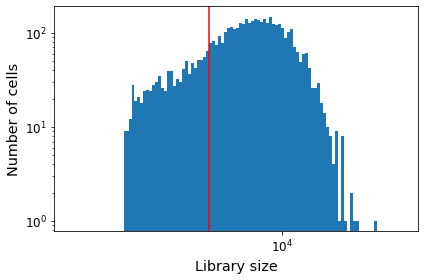

In [6]:
scprep.plot.plot_library_size(T1, percentile=20)

In [7]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

#### 4. Merge all datasets and create a vector representing the time point of each sample

In [8]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),...,ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='preprocessing'></a>
## 2. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Filtering by library size (if we did not do this prior to combining batches)
2. Removing genes that are expressed in relatively few cells.
3. Removing dead cells

We filter dead cells after library size normalization, since library size is not necessarily related to cell state.

** Filtering I: Library size filtering **

We did this before, because the library size correlated strongly with our samples. However, if we wanted to do something simplier, we could have run the following here instead:

`EBT_counts, sample_labels = scprep.filter.library_size_filter(EBT_counts, sample_labels, cutoff=2000)`

#### Filtering II: Remove rare genes

We eliminate genes that are expressed in 10 cells or fewer.

In [9]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [10]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

#### Filtering III: Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

<AxesSubplot:xlabel='Gene expression', ylabel='Number of cells'>

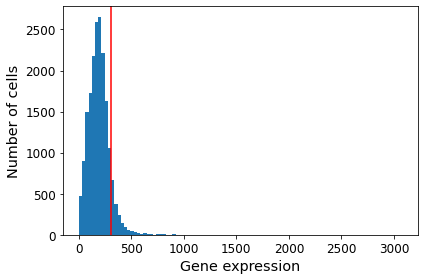

In [11]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [12]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [13]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

<a id='embedding'></a>
## 3. Embedding Data Using PHATE

### 3.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Since we are looking for subtle structure and we expect some of the trajectories to be sparse, we might want to decrease `knn` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `knn` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. We'll also reduce `alpha` here to 15 to partially offset the decreased connectivity as a result of decreasing `knn`.

In [14]:
phate_operator = phate.PHATE(n_jobs=-2, random_state=42)
Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 32.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 16.23 seconds.
    Calculating affinities...
    Calculated affinities in 1.41 seconds.
  Calculated graph and diffusion operator in 51.83 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.13 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.97 seconds.
  Calculated landmark operator in 19.73 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.51 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.88 seconds.
Calculated PHATE in 79.29 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

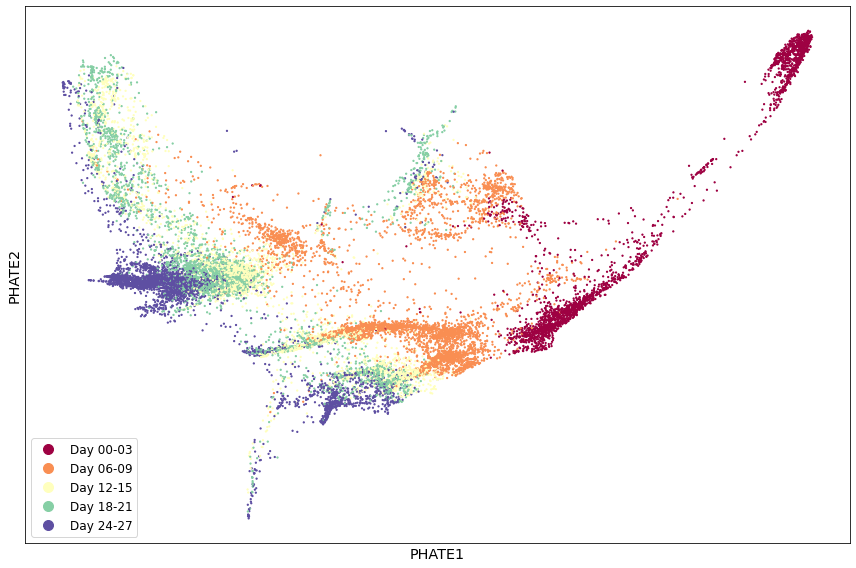

In [15]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<a id='trajectory'></a>
# 4. Evaluating with TrajectoryNet

This section is adapted from [this evaluation notebook](https://github.com/KrishnaswamyLab/TrajectoryNet/blob/master/notebooks/EB-Eval.ipynb). This shows how to use backwards trajectories computed through TrajectoryNet in the gene space.

We have precomputed `backward_trajectories.npy` which is an array of shape `[timepoints, cells, pcs]` and the same one used in the paper using the following command:

```
python main.py --save [SAVE_DIR] --dataset EB-PCA --top_k_reg 0.1 --training_noise 0.0 --max_dim 5
```
This is essentially the default with a small amount of density regularization (called top_k_reg). This computes the model and saves some checkpoints, the final weights are stored in `checkpt.pt`. The main arguments experimented with in the paper are `--top_k_reg` (Density regularization) and `--vecint` (Velocity regularization). 

We then run:
```
python eval.py --save [SAVE_DIR] --dataset EB-PCA --top_k_reg 0.1 --training_noise 0.0 --max_dim 5
```
Which creates the `backwards_trajectories.npy` in the `[SAVE_DIR]` directory from the saved model.

The full outputs for this training run can be found in `results/fig8_results/`

These trajectories take points in the final timepoint and integrate them backwards in 100 evenly spaced timepoints to the starting timepoint. This means we now a have data that represents the inferred "paths" taken through the embedding space to the output. The case where we have an invertible embedding such as PCA, this allows us to get approximate trajectories in gene space.

In this case we performed TrajectoryNet on 5d PCA on the EB data. We then can compute the trajectories in gene space.

In [16]:
zs = np.load('../results/fig8_results/backward_trajectories.npy')

In [17]:
zs.shape

(100, 3332, 5)

This output from TrajectoryNet `zs` is a tensor corresponding to 100 timepoints, 3332 cells in the last timepoint, and 5 principle components. In order to make the trajectories correspond to the PHATE embedding, we take the principle components stored in `phate_operator.graph.data_nu` and compute the mean and standard deviation with `StandardScaler`. We then scale the `zs` by the scale and mean of the first 5 principle components and plot the trajectories for a sample of cells from Day 24-27.

In [18]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(phate_operator.graph.data_nu)

StandardScaler()

In [19]:
phate_operator.graph.data_nu.shape

(16821, 100)

In [20]:
zss = zs * scaler.scale_[:5] + scaler.mean_[:5]

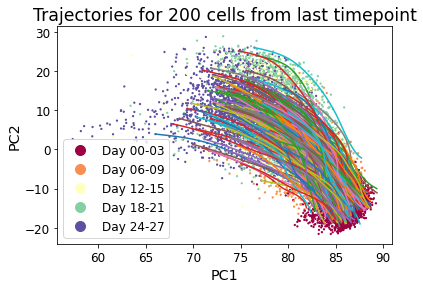

In [21]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(phate_operator.graph.data_nu, c=sample_labels, figsize=(30,15), cmap="Spectral",
                      ticks=True, label_prefix="PC", ax=ax, title='Trajectories for 200 cells from last timepoint')

for i in range(200):
    ax.plot(zss[:,i,0], zss[:,i,1])

In [22]:
trajectory_gene_space = np.dot(zss, phate_operator.graph.data_pca.components_[:5,:])

In [23]:
trajectory_gene_space.shape

(100, 3332, 17845)

In [24]:
genes = [x.split(' ')[0] for x in EBT_counts.columns]

In [25]:
eb_marker_genes = np.loadtxt('eb_genes.txt', dtype='str')

In [26]:
genes_index = {}

In [27]:
for gene in eb_marker_genes:
    genes_index[gene] = genes.index(gene)

In [28]:
trajectory_eb = trajectory_gene_space[:,:,np.array(list(genes_index.values()))]

In [29]:
np.save('trajectory_eb.npy', trajectory_eb)

In [30]:
trajectory_eb_magic = np.zeros((100,3332,68))

In [31]:
m_op = magic.MAGIC()
for i in range(100):
    trajectory_eb_magic[i,:,:] = m_op.fit_transform(trajectory_eb[i,:,:])

Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.74 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.77 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.75 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.77 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.47 seconds.
  Calculated graph and diffusion operator in 0.94 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 0.96 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.74 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.77 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.54 seconds.
  Calculated graph and diffusion operator in 1.02 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 1.05 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.53 seconds.
  Calculated graph and diffusion operator in 0.97 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 1.00 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.49 seconds.
  Calculated graph and diffusion operator in 0.91 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.94 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.48 seconds.
  Calculated graph and diffusion operator in 0.94 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.96 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.49 seconds.
  Calculated graph and diffusion operator in 0.95 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.98 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.44 seconds.
  Calculated graph and diffusion operator in 0.92 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.95 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.91 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.95 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.87 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.90 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.88 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.91 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.44 seconds.
  Calculated graph and diffusion operator in 0.89 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.92 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.44 seconds.
  Calculated graph and diffusion operator in 0.91 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.94 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.88 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.90 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.81 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.48 seconds.
  Calculated graph and diffusion operator in 0.98 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 1.00 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.89 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.87 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.89 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.91 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.46 seconds.
  Calculated graph and diffusion operator in 0.90 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.93 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.89 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.92 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.81 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.81 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.87 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.89 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.88 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.90 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.76 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.78 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.81 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.75 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.77 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.79 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.87 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.76 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.78 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.37 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.80 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.87 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.88 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.90 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.38 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.79 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.82 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.86 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.87 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.88 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.83 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.85 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.92 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.94 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.42 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.87 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.89 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.87 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.89 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.83 seconds.
Calculating MAGIC...
  Running MAGIC on 3332 cells and 68 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.84 seconds.


/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))
/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [32]:
np.save('trajectory_eb_magic.npy', trajectory_eb_magic)

## Genes of Interest

We then define "end genes" in this dataset representing 4 different cell populations. We run MAGIC on the original counts for these genes (plus 9 other potential genes of interest) and visualize the imputed expression.

In [33]:
end_genes = ['PDGFRA ', 'HAND1', 'SOX17', 'ONECUT2', ]
end_points = ['Muscle', 'Cardiac', 'Endothelial', 'Neuronal',]

colors = dict(zip(*[end_genes, [plt.get_cmap('tab10')(i+1) for i in range(len(end_genes))]]))

In [34]:
other_genes = ['GATA6 ', 'SATB1', 'T ', 'EOMES', 'NANOG', 'TNNT2', 'DLX1', 'TBX18', 'MAP2 ']
genes_of_interest = [*other_genes, *end_genes]

genes_of_interest_end = scprep.select.get_gene_set(EBT_counts, starts_with=end_genes)
genes_of_interest_full = scprep.select.get_gene_set(EBT_counts, starts_with=genes_of_interest)

In [35]:
genes_mask = EBT_counts.columns.isin(genes_of_interest_full)
genes = EBT_counts.columns[genes_mask]

In [36]:
inverse = np.dot(zss, phate_operator.graph.data_pca.components_[:5, genes_mask])
end_gene_indexes = [(np.where(genes_of_interest_full == gene)[0][0]) for gene in genes_of_interest_end]

In [37]:
m_op = magic.MAGIC()
m_op.graph = phate_operator.graph
EBT_magic = m_op.transform(EBT_counts, genes=genes_of_interest_full)

/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:589: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculating imputation...
Calculated imputation in 0.04 seconds.


/home/atong/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


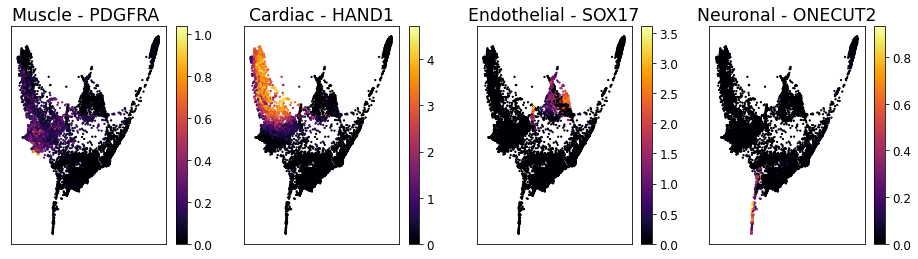

In [38]:
fig, ax = plt.subplots(1,len(end_genes), figsize=(4*len(end_genes),4))
ax = ax.flatten()
for i in range(len(end_genes)):
    scprep.plot.scatter2d(Y_phate, 
                          c=EBT_magic[scprep.select.get_gene_set(EBT_counts, starts_with=end_genes[i])], 
                          ax=ax[i],
                          title='%s - %s' % (end_points[i], end_genes[i]),
                          ticks=[],
                         )

## Plot cellular trajectories

We define `EBT_5` as the counts from the last timepoint, and we select the top 9 cells for each end gene with highest expression in this last timepoint. We then plot the trajectories from these cells.

In [39]:
EBT_5 = EBT_counts[sample_labels == 'Day 24-27']

In [40]:
masks = {}
top_idxs = {}
for gene in end_genes:
    top_idx = np.array(EBT_5[scprep.select.get_gene_set(EBT_counts, starts_with=gene)]).flatten().argsort()[-9:]
    top_mask = np.array(pd.Series(range(3332)).isin(top_idx))
    masks[gene] = top_mask
    top_idxs[gene] = top_idx
    print(gene, top_idx)

PDGFRA  [1896 2642  488  748  664  697 1419  300  432]
HAND1 [1959 3195  936 2133  375  668  501 2484 1476]
SOX17 [2053 2595 2664 1988 2353 1129 2823  738  532]
ONECUT2 [2920  555 2283  718 1275 2125 1838 2129 2277]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

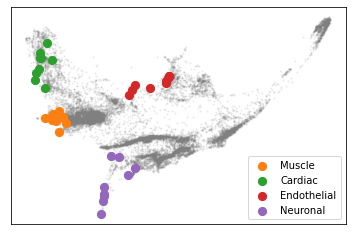

In [41]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(Y_phate, c='Gray', alpha=0.1, ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'][masks[gene]], 
                          ax=ax, c = colors[gene], label=end_points[i], ticks=[])
    
plt.legend()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

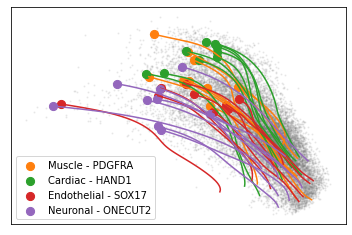

In [42]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(phate_operator.graph.data_nu, c='Gray', alpha=0.1, ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(phate_operator.graph.data_nu[sample_labels=='Day 24-27'][masks[gene]], ax=ax, 
                          label='%s - %s' % (end_points[i], end_genes[i]), c=colors[gene], ticks=[])

for gene in end_genes:
    for g in top_idxs[gene]:
        ax.plot(zss[:,g,0], zss[:,g,1], c=colors[gene])
plt.legend()

## Plot gene expression patterns

For these 36 cells (9 for each end gene), we plot the gene expression changes over the 100 timepoints and determine how different subsets of cells show different dynamical behavior.

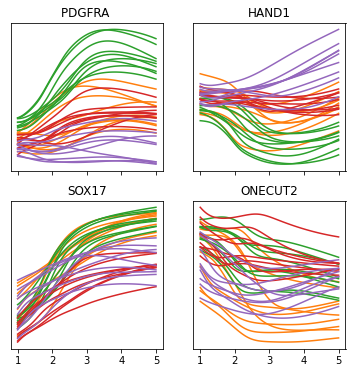

In [43]:
fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True)
ax = ax.flatten()

for i, gene in enumerate(end_genes):
    for j, eg in enumerate(end_genes):
        for cell in top_idxs[eg]:
            ax[i].plot(np.linspace(1,5,100)[::-1], inverse[:,cell,end_gene_indexes[i]], c=colors[eg])
            ax[i].set_title(gene)
            ax[i].set_yticks([])
            ax[i].set_xticks(range(1,6))